In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import copy
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

In [2]:
# Line class to store line characteristics
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # recent detected lines
        self.recent_lines = []
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients of the last n fits of the line
        self.recent_fits = []
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # paired lane line
        self.paired = None
        
    def calculate_best_x(self):
        '''
        Purpose: calculate the mean x values for the past n lines
        '''
        if len(self.recent_xfitted) > 1:
            
            self.bestx = np.array(self.recent_xfitted).T.mean(axis=1)
        else:
            self.bestx = self.allx
    def calculate_best_fit(self):
        '''
        Purpose: calculate the mean polynomial fit values for the past n lines
        '''
        if len(self.recent_fits) > 1:
            self.best_fit = np.array(self.recent_fits).T.mean(axis=1)
        else:
            self.best_fit = self.current_fit
    def perform_checks(self):
        '''
        Purpose: perform validation checks on line, set detected
                 to False if fails, True if passes
        '''
        
        line_passes = True
        self.detected = True
        # check if recent line exists, otherwise no basis for comparison and no checks will be performed
        if self.recent_lines:
            # most recent previous lane line
            most_recent = self.recent_lines[-1]
            # calculate difference between current and previous lane line fits
            self.diffs = self.current_fit - most_recent.current_fit
            
            # check if radius of curvature is relatively similar, fail if not
            if abs(self.radius_of_curvature - most_recent.radius_of_curvature) >= 1000:
                line_passes = False
                
            # check if horizontal distance between left and right lines is reasonable (< 5 m), fail if not
            if np.max(abs(self.allx - self.paired.allx)) > (5*600/3.7):
                line_passes = False
               
            # check that paired lane lines are roughly parallel (compare slopes), fail if not
            s1 = (self.ally[0]-self.ally[-1])/(self.allx[0]-self.allx[-1])
            s2 = (self.paired.ally[0]-self.paired.ally[-1])/(self.paired.allx[0]-self.paired.allx[-1])
            if abs(s2 - s1) > 1:
                line_passes = False
            # if line fails validation, set detected to False
            if not line_passes:
                self.detected = False
            
            

In [18]:
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
%matplotlib inline    

# retrieve all calibration images
cal_images = glob.glob('./camera_cal/*')
objpoints = []
imgpoints = []

# nx, ny are number of corners in x and y dimensions respectively
nx = 9
ny = 6

# initialize object points to zeros, reshape
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# loop through all calibration images
for fname in cal_images:
    
    # read image, convert to grayscale
    img = cv2.imread(fname)   
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 

    # find chessboard corners for image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    
    # if chessboard corners found
    if ret == True:
        
        # Draw and display the corners, append to list of corners and object points
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        imgpoints.append(corners)
        objpoints.append(objp)
        
# calibrate camera matrix and distortion coefficients        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# perform undistortion on test images, create test_images array
test_image_names = glob.glob('./test_images/*')
test_images = []

for i in range(len(test_image_names)):
    img = plt.imread(test_image_names[i])
    undist = undistort_image(img,mtx,dist)
    test_images.append(undist)

In [533]:
# Support functions required for pipeline

def undistort_image(img,mtx,dist):
    '''
    Purpose: Undistort images using camera matrix and distortion coefficients
    Inputs: 
        img - image to undistort
        mtx - camera matrix
        dist - distortion coefficients
    Outputs:
        undist - undistored image
    '''
    undist = cv2.undistort(img,mtx,dist, None, mtx)
    return undist

def region_of_interest(img, vertices):
    """
    Purpose: 
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    
    Inputs:
        img - image to mask
        vertices - vertices describing region of interest to keep
    Outputs:
        masked_image - masked image
    
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def color_gradient_transform(img, sx_thresh=(20,100),r_thresh=(220,255), u_thresh=(150,255)):
    '''
    Purpose: perform image transform using gradient thresholding and saturation threshold
    Inputs: 
        img - input image to transform
        r_thresh - lower and upperbound tuple with red value thresholds
        u_thresh - lower and upperbound tuple for u channel of yuv thresholds
        sx_thresh - lower and upperbound tuple with sobelx gradient thresholds
    Outputs:
        combined_binary - transformed image
    '''
    img = np.copy(img)
    
    r_channel = img[:,:,0]
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    # Convert to YUV color space and separate the u channel
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV).astype(np.float)
    u_channel = yuv[:,:,1]
    # Convert to HSL color space and separate the L channel
    hsl =  cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsl[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    u_binary = np.zeros_like(u_channel)
    u_binary[(u_channel >= u_thresh[0]) & (u_channel <= u_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, u_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[ ((u_binary == 1)  |  (r_binary ==1)) | (sxbinary ==1)] = 1
    
    return combined_binary

def warp_image(M,img):
    '''
    Purpose: perform image warping using a perspective warp matrix
    Inputs: 
        M - warping matrix
        img - image to warp
    Outputs:
        warped - warped image
    '''

    #Warp an image using the perspective transform, M:

    warped = cv2.warpPerspective(img, M, img.shape[:2:][::-1], flags=cv2.INTER_LINEAR)
    return warped

def fit_lane_lines_new(binary_warped, left_line, right_line):
    '''
    Purpose: Fit lane lines to a warped image
    Inputs:
        binary_warped - a binary warped image
        left_line, right_line - line objects to store fitted lines
    Outputs:
        left_line - fitted left lane line
        right_line - fitted right lane line
    '''
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each if pixels were found
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    if len(leftx) > minpix:
        
        left_fit = np.polyfit(lefty, leftx, 2)
        left_line.current_fit = left_fit
        left_line.detected = True
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        left_line.allx = left_fitx
        left_line.ally = ploty
        # calculate radius of curvature
        left_line.radius_of_curvature = calculate_radius(left_line)
        # set paired line as the right lane line
        left_line.paired = right_line
    if len(rightx) > minpix:
        right_fit = np.polyfit(righty, rightx, 2)
        right_line.current_fit = right_fit
        right_line.detected = True
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        right_line.allx = right_fitx
        right_line.ally = ploty
        # calculate radius of curvature
        right_line.radius_of_curvature = calculate_radius(right_line)
        # set paired line as the left lane line
        right_line.paired = left_line
    return left_line, right_line

def fit_existing_lane_lines(binary_warped,prev_left_line,prev_right_line,new_left,new_right):
    '''
    Purpose: fit lane lines given previous lane lines were found
    Inputs:
        binary_warped - image to have lines fit to
        prev_left_line, prev_right_line - lane lines from previous frame
        new_left, new_right - lane line objects to fit
    Outputs:
        new_left, new_right - fitted lane lines
    '''
    
    # set left and right fit to the previous lines' fits
    left_fit = prev_left_line.current_fit
    right_fit = prev_right_line.current_fit
    leftx = []
    rightx = []
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # margin to look within for new lines and minimum pixels for detection
    margin = 100
    minpix = 50
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    if len(left_lane_inds) > 0:
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
    if len(right_lane_inds) > 0:
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # default detected values to false
    new_left.detected = False
    new_right.detected = False
    

    # Fit a second order polynomial to left and right lines if detected, perform validation

    left_fit = np.polyfit(lefty, leftx, 2)
    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    new_left.allx = left_fitx
    new_left.ally = ploty
    new_left.current_fit = left_fit
    new_left.radius_of_curvature = calculate_radius(new_left)
    new_left.paired = prev_left_line
    new_left.perform_checks()


    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    new_right.allx = right_fitx
    new_right.ally = ploty
    new_right.current_fit = right_fit
    new_right.radius_of_curvature = calculate_radius(new_right)
    
    # if validation passed for left line, set paired line to new left line. Otherwise,
    # set to the old left line
    if new_left.detected:
        new_right.paired = new_left
    else:
        new_right.paired = prev_left_line
    new_right.perform_checks()
    # no line found, return previous line
    
    return new_left, new_right


def calculate_radius(line):
    '''
    Purpose: determine radius of curvature of lane line
    Inputs:
        line - line to calculate radius of curvature for
    Outputs:
        curverad - radius of curvature in meters
    '''
    
    x = line.allx
    # Define y-value where we want radius of curvature.
    # Used maximum y-value, corresponding to the bottom of the image
    ploty = line.ally
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/600 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, x*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    # Now our radius of curvature is in meters
    return curverad


def calculate_distance_from_center(img,left_line,right_line):
    '''
    Purpose: determine distance of car from center of lane
    Inputs:
        img - image to base calculation off of
        left_line, right_line - left and right lane lines
    Outputs:
        offset - offset in m from center of lane line (+ is left of center)
    '''
        
    xm_per_pix = 3.7/600 # meters per pixel in x dimension
    
    # Find points on left and right lines at the max position in y
    leftx = left_line.best_fit
    rightx = right_line.best_fit
    
    y_eval = 720
    left_x = (y_eval**2)*leftx[0] + y_eval*leftx[1] + leftx[2]
    right_x  = (y_eval**2)*rightx[0] + y_eval*rightx[1] + rightx[2]
    
    # offset is the midpoint of the detected lane minus the center of the image
    offset = (float((right_x+left_x)/2)-float(img.shape[1]/2))*float(xm_per_pix)
    return offset
    
# Warp the detected lane boundaries back onto the original image.

def add_lane_boundaries(img, warped, Minv, left_line, right_line):
    '''
    Purpose: add lane lines to an image
    Inputs:
        img - image to add lane lines to
        warped - warped image in bird's eye view
        Minv - inverse transformation matrix for warped image
        left_line, right_line - left and right lane line objects
    Outputs:
        result - image with lane lines appended
    '''
    # make blank 3 channel image
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.bestx, left_line.ally]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, right_line.ally])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

def append_labels(img, radius_of_curvature, center_offset):
    '''
    Purpose: append labels for radius of curvature and offset from center to image
    Inputs:
        img - image to append text to
        radius_of_curvature - radius of curvature in m to append (average of left and right)
        center_offset - offset from center (positive is left of center)
    Outputs:
        out_img - image with text appended
    '''
    
    # determine if left or right of center
    if center_offset > 0:
        side = 'left'
    else:
        side = 'right'
    # append headings
    out_img = cv2.putText(img,'Radius of Curvature is ' + str(int(radius_of_curvature)) + 'm',(10,80), cv2.FONT_HERSHEY_SIMPLEX , 2,(255,255,255),2,cv2.LINE_AA)
    out_img = cv2.putText(out_img,'Vehicle is ' + str(format(abs(center_offset),'0.2f')) + 'm ' + side + ' of center',(10,130), cv2.FONT_HERSHEY_SIMPLEX , 2,(255,255,255),2,cv2.LINE_AA)
    return out_img

In [544]:
def add_lane_lines(img, mtx=mtx, dist=dist,prev_left = [],prev_right = []):
    '''
    Purpose: pipeline to add lane lines to an image
    Inputs:
        img - image to process
        mtx - camera calibration matrix
        dist - camera distortion coefficients
        prev_left - deque of previous left lane lines (if any)
        prev_right - deque of previous right lane lines (if any)
    '''
    
    # vertices for region of interest mask
    y_cutoff = 0
    x_left_top_cutoff = 200
    x_left_bottom_cutoff = 200
    x_right_top_cutoff = 1200
    x_right_bottom_cutoff = 1200
    vertices = np.array([[(x_left_bottom_cutoff,img.shape[0]),
                          (x_left_top_cutoff, y_cutoff), 
                          (x_right_top_cutoff, y_cutoff), 
                          (x_right_bottom_cutoff,img.shape[0])]])
    
    # source and destination vertices for warping matrix M
    src = np.float32([
                    [685, 450],
                    [1100,720],
                    [595,450],
                     [200,720],
                     ])

    dst = np.float32([
                        [960,0], 
                        [960,720], 
                        [320, 0], 
                      [320, 720],
                       
                     ])
    M = cv2.getPerspectiveTransform(src, dst)

    #Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #undistort image
    undist = undistort_image(img,mtx,dist)
    
    # apply region of interest mask
    
    
    # detect lane lines using gradient and colour thresholding
    combined_binary = color_gradient_transform(undist)
    
    # perform bird's eye view warp
    warped_image = warp_image(M,combined_binary)
    warped_image = region_of_interest(warped_image,vertices)
    # create new lane line objects
    left_line = Line()
    right_line = Line()
    
    # set recent lines to those passed to this function
    left_line.recent_lines = prev_left
    right_line.recent_lines = prev_right
    
    # append previous x values and polynomial coefficients to line objects
    for i in range(len(prev_left)):
        left_line.recent_xfitted.append(prev_left[i].allx)
        left_line.recent_fits.append(prev_left[i].current_fit)
    for i in range(len(prev_right)):
        right_line.recent_xfitted.append(prev_right[i].allx)
        right_line.recent_fits.append(prev_right[i].current_fit)
    
    # if both left and right lines were not given to function, find new ones using windowing
    # method and perform validation
    if not (prev_left and prev_right):
        left_line, right_line = fit_lane_lines_new(warped_image, left_line, right_line)
        left_line.perform_checks()
        right_line.perform_checks()
    else:
        # otherwise try to find near previous lane lines
        left_line, right_line = fit_existing_lane_lines(warped_image,prev_left[-1],prev_right[-1],left_line,right_line)
    
    # if lane line found, perform smoothing calculations
    if left_line.detected:
        left_line.recent_xfitted.append(left_line.allx)
        left_line.recent_fits.append(left_line.current_fit)
        left_line.calculate_best_x()
        left_line.calculate_best_fit()
    else:
        # otherwise, use previous lane line and set to not detected
        left_line = copy.deepcopy(prev_left[-1])
        left_line.detected = False
    # if lane line found, perform smoothing calculations
    if right_line.detected:
        right_line.recent_xfitted.append(right_line.allx)
        right_line.recent_fits.append(right_line.current_fit)
        right_line.calculate_best_x()
        right_line.calculate_best_fit()
    else:
        # otherwise, use previous lane line and set to not detected
        right_line = copy.deepcopy(prev_right[-1])
        right_line.detected = False
    
    # determine offset from center
    center_offset = calculate_distance_from_center(warped_image,left_line,right_line)
    
    # add lane lines to undistorted image
    updated_image = add_lane_boundaries(undist,warped_image,Minv, left_line, right_line)
    
    # set pairings for left and right lane lines
    left_line.paired = right_line
    right_line.paired = left_line
    
    # append labels to image
    updated_image = append_labels(updated_image,(left_line.radius_of_curvature+right_line.radius_of_curvature)/2,center_offset)
    #plt.plot(left_fitx,ploty)
    return updated_image,left_line, right_line

In [288]:
# dequeues to keep track of recent lane lines with a maximum of 3 to be used for smoothing
global prev_left_lines 
prev_left_lines = deque(maxlen=5)
global prev_right_lines 
prev_right_lines = deque(maxlen=5)


def process_image(image):
    '''
    Purpose: process frame of image using lane fitting pipeline while keeping track of previous lane lines
    Inputs:
        image - frame to be processed
    Outputs:
        result - processed frame
    '''
    result,new_left_line,new_right_line = add_lane_lines(image,prev_left=prev_left_lines,prev_right=prev_right_lines)
    # if lane lines found, append to dequeue (will remove one as well if reached max size), otherwise just remove a 
    # lane line from dequeue
    if new_left_line.detected:
        prev_left_lines.append(new_left_line)
    else:
        prev_left_lines.pop()
    if new_right_line.detected:
        prev_right_lines.append(new_right_line)
    else:
        prev_right_lines.pop()
    return result
    
    

In [546]:
import sys
# change recursion limit to avoid recursion errors depending on dequeue limit
sys.setrecursionlimit(10000)  

# process coloured video
project_output = './project_video_out.mp4'
clip1 = VideoFileClip("./project_video.mp4")
out_clip = clip1.fl_image(process_image) 
%time out_clip.write_videofile(project_output, audio=False)


[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4


100%|█████████▉| 1260/1261 [03:25<00:00,  6.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 

CPU times: user 14min 34s, sys: 2.48 s, total: 14min 37s
Wall time: 3min 26s


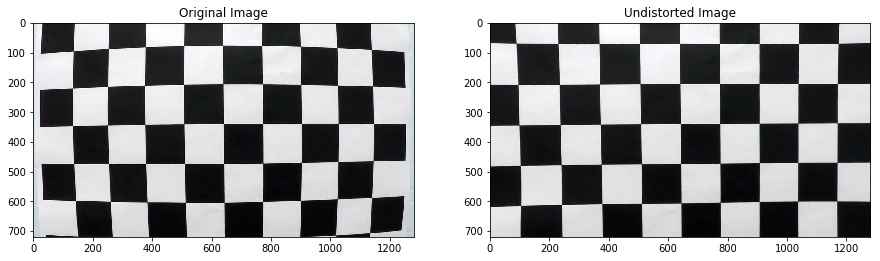

In [349]:
# image 1 - camera calibration

%matplotlib inline    

cal_images = glob.glob('./camera_cal/*')

fname = cal_images[10]

img = cv2.imread(fname)   
        
img = cv2.imread(cal_images[0])
dst = cv2.undistort(img, mtx, dist, None, None)
fig = plt.figure(figsize=(15,15))
plt.subplot(1 , 2 , 1)
plt.title('Original Image')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Undistorted Image')
plt.imshow(dst)

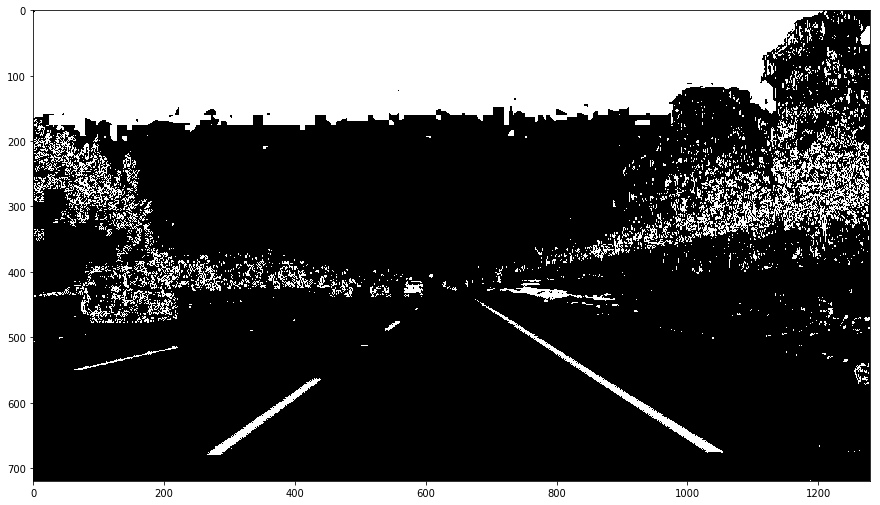

In [539]:
#image 3 - thresholded and region-masked image
test_image = plt.imread('./test_images/straight_lines2.jpg')
y_cutoff = 300
x_left_top_cutoff = 604
x_left_bottom_cutoff = 150
x_right_top_cutoff = 600
x_right_bottom_cutoff = 1240
vertices = np.array([[(x_left_bottom_cutoff,img.shape[0]),
                      (x_left_top_cutoff, y_cutoff), 
                      (x_right_top_cutoff, y_cutoff), 
                      (x_right_bottom_cutoff,img.shape[0])]])
test_img = color_gradient_transform(test_image, sx_thresh=(20,100),r_thresh=(220,255), u_thresh=(150,255))

plt.figure(figsize=(15,15))
plt.imshow(test_img,cmap='gray')

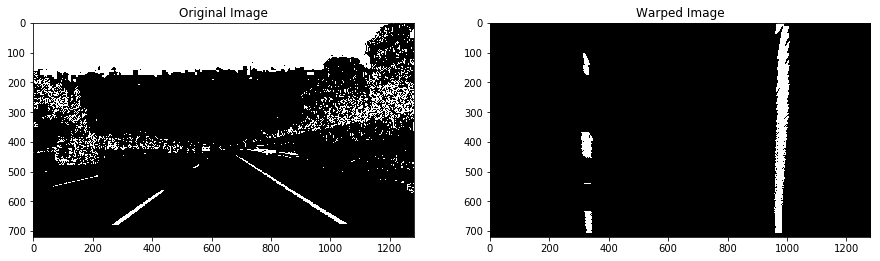

In [547]:
# image 4 - warping to bird's eye view
src = np.float32([
                    [685, 450],
                    [1100,720],
                    [595,450],
                     [200,720],
                     ])

#[0,0],[300,0],[0,300],[300,300]
dst = np.float32([
                    [960,0], 
                    [960,720], 
                    [320, 0], 
                  [320, 720],



                 ])
M = cv2.getPerspectiveTransform(src, dst)
test_img_warped = warp_image(M,test_img)
plt.figure(figsize=(15,15))
plt.subplot(1 , 2 , 1)
plt.title('Original Image')
plt.imshow(test_img,cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Warped Image')
plt.imshow(test_img_warped,cmap='gray')

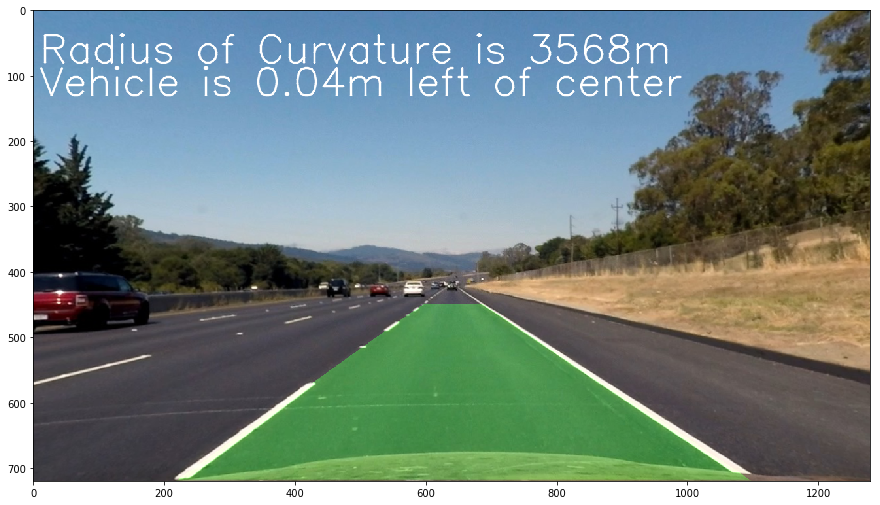

In [545]:
# image 5 - example of output image
test_image = plt.imread('./test_images/straight_lines2.jpg')
test_image = undistort_image(test_image,mtx=mtx,dist=dist)
test_image_final,left_lane,right_lane = add_lane_lines(test_image)
plt.figure(figsize=(15,15))
plt.imshow(test_image_final)